# Introduction to Autoencoders and Variational Autoencoders

In this tutorial we will use Autoencoders (AE) and Variational Autoencoders (VAE) on sea surface temperature (SST) anomalies in the tropical Pacific.

The following packages are needed for this tutorial:

In [2]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
import aeutils as ut
plt.style.use("./../plotting.mplstyle")

## 1. Familiarize yourself with the data

Many atmospheric phenomena are driven by the oceans, since they contain most of the heat. Sea surface temperatures (SST) fields can help us predict and understand many atmospheric processes. Anomalies in the Pacific SST can lead to large climatic changes world wide. 

The monthly SST data from 1950-1979 and 1979-2021 are taken from [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data are regridded on a $5^\circ \times 5^\circ$ resolution, detrended and then subtracted from their monthly climatology. The data can be found in "04_vae/data".

We use xarray to read the .nc files:

In [3]:
da = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']
da

<xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...

We can easily plot the SST anomaly maps for some time points using the internal plotting function of xarray:

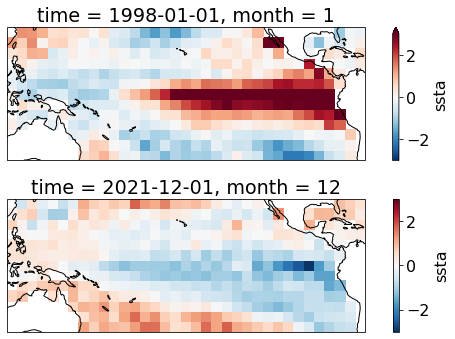

In [4]:
fig, axs = plt.subplots(2, subplot_kw=dict(
    projection= ctp.crs.PlateCarree(central_longitude=180)))
for i, t in enumerate(['1998-01', '2021-12']):
    da.sel(time=t).plot(ax=axs[i], vmin=-3, vmax=3, transform=ctp.crs.PlateCarree(central_longitude=180), cmap=mpl.cm.RdBu_r)
    axs[i].coastlines()

Nicer plots can be obtained by using cartopy. This however also requires many more lines of codes which you can find in the aeutils.py.

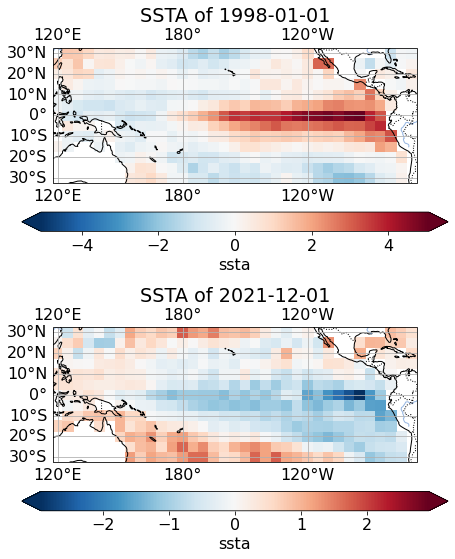

In [5]:
fig = plt.figure(figsize=(8,8))
for i, t in enumerate(['1998-01-01', '2021-12-01']):
    ax = fig.add_subplot(2,1,i+1, projection=ctp.crs.PlateCarree(central_longitude=180))
    ut.plot_map(da.sel(time=t), ax=ax, central_longitude=180)
    ax.set_title(f'SSTA of {t}')

Each point on the map is a time-series. We can select coordinates using the ```da.sel()``` method (see [xarray tutorial](https://xarray.pydata.org/en/stable/user-guide/indexing.html)) 

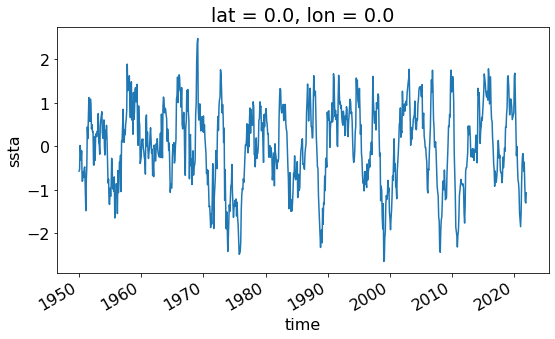

In [6]:
# Select single point
ts_sample = da.sel(lat=0, lon=0, method='nearest')
# Plot time-series
ts_sample.plot()

### El Nino Southern Oscillation (ENSO)

The largest interanual variability of the climate is characterized by SST anomalies in the tropical Pacific, called the **El Nino Southern Oscillation (ENSO)**. ENSO has a normal, warm phase called **El Nino** and a cold phase called **La Nina** with different impacts on global climate.

The phase of ENSO is defined using the average time series over the Nino3.4 region. The warm phase is defined as Nino3.4 > 0.5 and the cold phase as Nino3.4<-0.5. 

![Nino](img/nino_regions.png) [Ref.](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)


With xarray selecting boxes and taking averages is an easy thing to do:

In [7]:
nino34_region = da.sel(lat=slice(-5,5), lon=slice(10, 60))
nino34 = nino34_region.mean(dim=('lon', 'lat'), skipna=True)

Text(0, 0.5, 'Nino3.4 index')

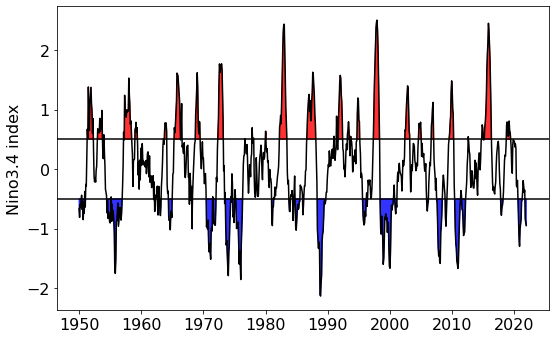

In [8]:
# Plot Nino3.4 index
fig, ax = plt.subplots()
ax.plot(nino34['time'].data, nino34.data, '-k')
ax.fill_between(nino34['time'].data, nino34.data, y2=0.5, where=nino34.data >= 0.5, color='r', alpha=0.8)
ax.fill_between(nino34['time'].data, nino34.data, y2=-0.5, where=nino34.data <= -0.5, color='b', alpha=0.8)
ax.axhline(-0.5, color='k')
ax.axhline(0.5, color='k')
ax.set_ylabel('Nino3.4 index')

## 2. Preprocess data for our deep learning framework

There are a whole zoo of deep learning libraries for python out there.

![Nino](img/dl_libraries.png) [Ref.](https://towardsdatascience.com/best-python-libraries-for-machine-learning-and-deep-learning-b0bd40c7e8c)

Here, we use pytorch since it is one of the most common used currently wich easily allows running your code on GPUs.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Pytorch use their own datatype, pytorch.Tensors which is very similar to numpy. In order to use our SST anomaly data as inputs to neural networks (NN) we have to preprocess the data. The following preprocessing steps are usually required: 

1. **Adapt input size**: Since we will use linear NN, we have to flatten the maps into vectors.

2. **Normalization**: Data should be normalized, e.g. between 0 and 1. For anomaly data this is not necessarily required since the data is already bounded and equally distributed around 0.

It is convinient to define a Dataset class with which we can use the Dataloader objects predefined by pytorch. 

In [10]:

class SSTA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.dataarray = dataarray
        self.time = self.dataarray['time'].data
        self.lat = self.dataarray['lat'].data
        self.lon = self.dataarray['lon'].data
        
        # Flatten map to vector
        X = self.dataarray.data.reshape(self.dataarray.shape[0], -1)
        # Remove Nans in vector
        self.idx_nan = np.isnan(X[0,:])
        self.X = X[:, ~self.idx_nan]
        

    def __len__(self):
        """Returns the number of datapoints."""
        return self.X.shape[0]
    

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.

        Returns:
            x (torch.Tensor): Datapoint
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = torch.from_numpy(self.X[idx]).float()
        label = {'idx': idx}

        return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()

        # Create array with NaNs
        x_map = np.ones((len(self.lat) * len(self.lon))) * np.NaN
        # fill array with sample
        x_map[~self.idx_nan] = x

        da_map = xr.DataArray(
            data=np.reshape(x_map, (len(self.lat), len(self.lon))),
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return da_map 
        

Lets have a look at our pytoch Dataset class.

In [11]:
dataset = SSTA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape[0]
print(f"Shape of NN input: {x_dim}")
print(f"Shape of original input: {da[0].shape}")

Shape of NN input: 394
Shape of original input: (13, 35)


When training a NN on data we always have to evaluate their performance on data which has not been used while training.

Therefore, we split the data randomly in a training and validation dataset, here 80% to 20%. 

In [12]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])

To process a datapoints in parallel pytorch offers a ```Dataloader```. The Dataloader allows to process a set of datapoints, i.e. minibatch at the same time. The size of the minibatch depends on the number of datapoints we have. 

In [13]:
# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## 3. Autoencoder

Now we can start defining our autoencoder (AE). AE are used to reconstruct high-dimensional data using NN with a narrow bottleneck layer. It is often used for dimensionality reduction, like Principal Component Analysis. AE are optimized to obtain good reconstructions. 

The Autoencoder consists of:

- The encoder network $g_\phi(x)$ translates the input $x$ to the low-dimensional latent code $z$.
- The decoder network $f_\theta(z)$ recovers the data from the latent code.

<img src="img/autoencoder_sketch.png" width="900"> [Ref.](https://lilianweng.github.io/posts/2018-08-12-vae/)


We find the parameters $\theta$ and $\phi$ to minimize the reconstruction error:

$L_{\mathrm{AE}}(\theta, \phi)=\frac{1}{n} \sum_{i=1}^{n}\left(\mathbf{x}^{(i)}-f_{\theta}\left(g_{\phi}\left(\mathbf{x}^{(i)}\right)\right)\right)^{2}$

Thus, both Encoder and Decoder are trained together.

In this case we build a very simple Autoencoder with: 

- Encoder: $x$ -> Linear(512) -> Linear(2) -> $z$
- Decoder: $z$ -> Linear(512) -> Linear(394) -> $x'$
          

In [14]:
class AE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
        ).to(self.device)

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        # Sum of point wise MSE
        rec_loss = torch.sum(torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        return rec_loss.mean()
        

Initialize the AE:

In [15]:
ae = AE(x_dim, z_dim=2)

print('Encoder:', ae.encoder)
print('Decoder:', ae.decoder)


Encoder: Sequential(
  (0): Linear(in_features=394, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=2, bias=True)
)
Decoder: Sequential(
  (0): Linear(in_features=2, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=394, bias=True)
)


**How many parameters does our model have?**

<img src="img/mlp.png" width="500"> [Ref.](https://commons.wikimedia.org/wiki/File:Multi-Layer_Neural_Network-Vector.svg)


In [16]:
if True:
    print('Number of encoder weights:', (512*394 + 512 + 512*2 + 2))
    print('Number of decoder weights:', (512*2 + 512 + 512*394 + 394)) 

    print("Number of trainable parameters of our model:",
        sum(p.numel() for p in ae.parameters() if p.requires_grad))

Number of encoder weights: 203266
Number of decoder weights: 203658
Number of trainable parameters of our model: 406924


### Training an NN

We train the NN by computing the loss for each minibatch and update the gradients using backpropagation. We iterate $N$ epochs over the whole training data. No gradients are computed for the validation data.

In [17]:
def train_epoch(model, dataloader, optimizer):
    """Train model for one epoch.

    Args:
        model (nn.Module): Model to train
        dataloader (torch.Dataloader): Dataloader of trainingsdata.
        optimizer (torch.optim): Optimizer of model parameters.

    Returns:
        mean_epoch_loss (float): training loss of one epoch
    """
    # set model into training mode
    model.train()

    epoch_loss = 0.0
    for i, data in enumerate(dataloader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        # encoding and decoding
        data, _ = data
        data = data.to(model.device)

        # loss function
        loss = model.loss(data)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss


def validate_epoch(model, dataloader):
    """Validate model for one epoch.

    Args:
        model (nn.Module): VAE model to train.
        dataloader (torch.Dataloader): Dataloader of validation data.

    Returns:
        mean_epoch_loss (float): Validation loss of one epoch.
    """
    # Set model into validation mode
    model.eval()

    epoch_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(model.device)

            # loss function
            loss = model.loss(data)
            epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss

In [18]:
# The training loop
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        ae, val_loader
    )
    train_epoch_loss = train_epoch(
        ae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 50
Train Loss: 99.6876
Val Loss: 160.9201
Epoch 2 of 50
Train Loss: 85.1502
Val Loss: 83.4815
Epoch 3 of 50
Train Loss: 80.6817
Val Loss: 81.7621
Epoch 4 of 50
Train Loss: 77.6183
Val Loss: 79.8846
Epoch 5 of 50
Train Loss: 76.5023
Val Loss: 80.4652
Epoch 6 of 50
Train Loss: 76.9646
Val Loss: 79.3726
Epoch 7 of 50
Train Loss: 76.2365
Val Loss: 78.4627
Epoch 8 of 50
Train Loss: 74.5498
Val Loss: 77.7297
Epoch 9 of 50
Train Loss: 74.2351
Val Loss: 78.5420
Epoch 10 of 50
Train Loss: 74.0312
Val Loss: 77.2114
Epoch 11 of 50
Train Loss: 73.4326
Val Loss: 77.8322
Epoch 12 of 50
Train Loss: 74.1876
Val Loss: 77.7702
Epoch 13 of 50
Train Loss: 75.2743
Val Loss: 77.3955
Epoch 14 of 50
Train Loss: 72.9189
Val Loss: 79.1494
Epoch 15 of 50
Train Loss: 72.7697
Val Loss: 77.0424
Epoch 16 of 50
Train Loss: 72.4995
Val Loss: 78.2257
Epoch 17 of 50
Train Loss: 71.5391
Val Loss: 76.7075
Epoch 18 of 50
Train Loss: 72.1041
Val Loss: 77.1487
Epoch 19 of 50
Train Loss: 71.6405
Val Loss: 77.1107
E

The first evaluation of the training is by plotting the loss on the training data and on the validation data for each epoch:

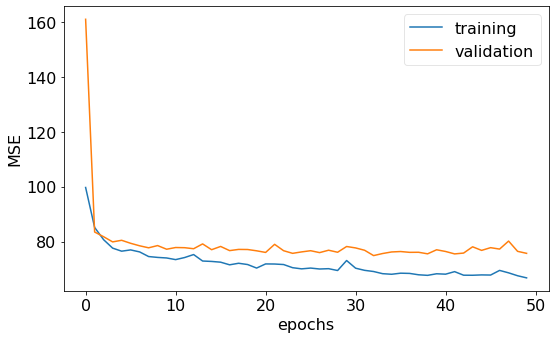

In [19]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('linear')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

We compare the input and reconstructed images qualitatively:

Text(0.5, 1.0, 'Reconstruced SSTA')

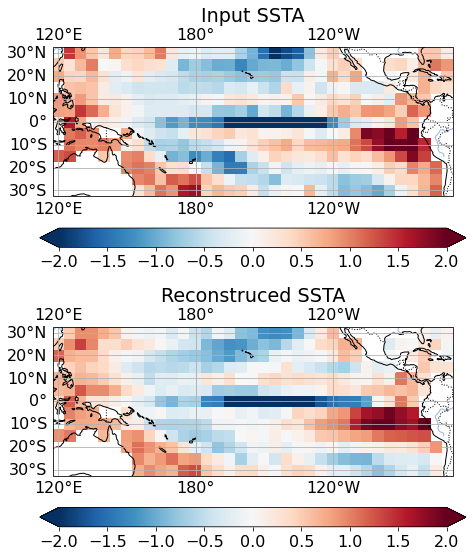

In [23]:
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, z = ae.forward(x.to(ae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec)

# Plotting
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree(central_longitude=180))
)
ut.plot_map(da_in, ax=ax1, central_longitude=180, vmin=-2, vmax=2)
ax1.set_title(f"Input SSTA")
ut.plot_map(da_rec, ax=ax2, central_longitude=180, vmin=-2, vmax=2)
ax2.set_title("Reconstruced SSTA")


### The latent space

The bottleneck layer or latent space is a compressed low dimensional representation of the input. In the following we will analyze the structure of the latent space. Thereby, we will encode all input datapoints to the latent space.

Text(0, 0.5, '$z_2$')

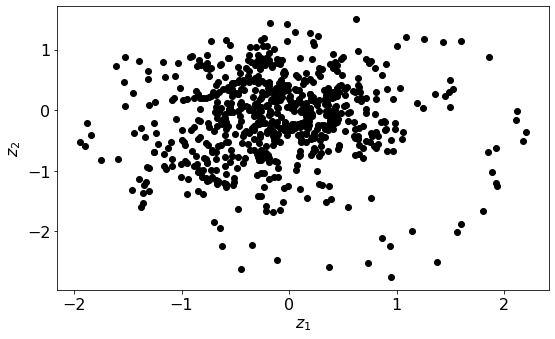

In [24]:
def encoding(model, dataloader):
    """Encoding dataset and store encoding.

    Args:
        model (nn.Module): AE model.
        dataloader (torch.Dataloader): Dataloader 

    Returns:
        encode (dict): Dictionary with encodings.
    """
    with torch.no_grad():
        encode = dict()
        for i, x in enumerate(dataloader):
            x, l = x
            # Encode data
            z = model.encoder(x.to(model.device))
            
            if i == 0:
                encode['z'] = z.cpu().detach().numpy()
                encode['idx'] = l['idx']
            else:
                encode['z'] = np.vstack([encode['z'], z.cpu().detach().numpy()])
                encode['idx'] = np.concatenate((encode['idx'], l['idx']))
    return encode

encode = encoding(ae, train_loader)

# Plot the encoding
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")

We can also for instance check how El Ninos and La Ninas are distributed in this space:

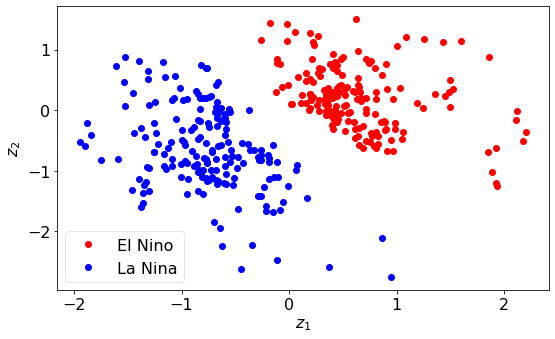

In [25]:
nino34_train = train_data.dataset.dataarray.sel(lat=slice(-5,5), lon=[10, 60]).mean(dim=('lon', 'lat'), skipna=True)

# get all encodings for El Nino conditions
nino_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data > 0.5)[0]))
# get all encodings for La Nina conditions
nina_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data < -0.5)[0]))


fig, ax = plt.subplots()
ax.plot(encode['z'][nino_idx, 0], encode['z'][nino_idx, 1], 'ro', label='El Nino')
ax.plot(encode['z'][nina_idx,0], encode['z'][nina_idx,1], 'bo', label='La Nina')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()


### Traversing the latent space

Another method for studying the latent space is by travsing (walking) through the low dimensional space and decoding each step.

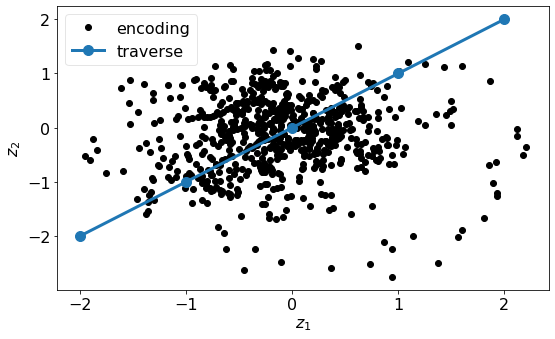

In [26]:
z_start = torch.Tensor([[0,0]])
z_eps = torch.Tensor([1,1])
z_range = torch.linspace(-2, 2, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1 ) + z_range.unsqueeze(1) * z_eps


# Plot latent space
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', label='encoding')
ax.plot(z_samples[:,0], z_samples[:,1], '-o', label='traverse', 
        markersize=10, linewidth=3)
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

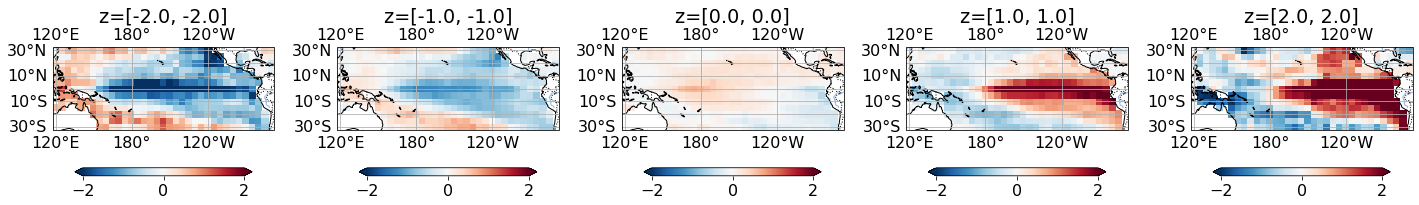

In [27]:
# Decode z
with torch.no_grad():
    traverse = ae.decoder(z_samples.to(ae.device))
    
# Plot reconstructions
fig, axs = plt.subplots(
    1, len(z_range), figsize=(len(z_range)*4, 4), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree(central_longitude=180))
)
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    ut.plot_map(da_rec, ax=axs[i], central_longitude=180, vmin=-2, vmax=2)
    axs[i].set_title(f"z={z_samples[i].tolist()}")

## 3. Variational Autoencoder

Variational Autoencoder is conceptually similar to an classical Autoencoder. VAEs are however mathematically quite different since we infer probability distributions over input $x$ and latent variables $z$. Instead of mapping the input $x$ to a fixed vectore, we map it into a conditional distribution which is parametrized by the encoder network. 

Our aim is to approximate the distribution of the data:

$x \sim p(x) = \int dz p(x|z) p(z)$ 

usind Bayes rule our problem formulation is 

$p(z|x) = \frac{p_\phi(x|z) p(z)}{\int_z dz p_\phi(x|z) p(z)}$

where:
- $p(z)$ is the prior
- $p_\phi(x|z)$ is the likelihood parametrized by the decoder network
- $p_\theta(z|x)$ is the posterior distribution parametrized by the encoder network


We can formulate this problem as an optimization using variational inference. Our objective is the evidence lower bound (ELBO) which needs to be maximized, i.e.

$\theta^*, \phi^* = \argmin_{\theta, \phi} L_{\text{VAE}}(\theta, \phi) = \argmin_{\theta, \phi} \left[ -\mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z} \mid \mathbf{x})} \log p_{\theta}(\mathbf{x} \mid \mathbf{z})+D_{\mathrm{KL}}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \| p_{\theta}(\mathbf{z})\right) \right]$.

The first term is called the *reconstruction loss* and the second term is often denoted as a *regularization*.

### Kullback-Leibler divergence

In the ELBO above, we use the Kullback-Leibler (KL) divergence to write our inference problem. The KL-divergence quantifies the distance between tow distributions $Q$ and $P$ and is defined as,

$ D_{\mathrm{KL}}(Q \mid P)=\mathbb{E}_{z \sim Q(z)} \log \frac{Q(z)}{P(z)} $

Note that the KL-divergence is not symmetric, i.e. $D_{\mathrm{KL}}(Q \mid P) \neq D_{\mathrm{KL}}(P \mid Q)$.

In the case above the KL-divergence basically measures the distance between the prior $p(z)$ and the approximate likelihood $q_{\phi}(\mathbf{z} \mid \mathbf{x})$.

For two gaussians $q(z) = \mathcal{N}_1(\mu_1, \sigma_1^2 1)$ and $p(z) = \mathcal{N}_2(\mu_2, \sigma_2^2 1)$ the KL-divergence can be computed analytically as,

$D_{KL}(q|p) = 0.5 * \left[ log(\sigma_2) - log(\sigma_1) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{\sigma_2^2 } -1 \right]$




In [28]:
def kl_normal(q_m, q_logv, p_m, p_logv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension.
 
    kl(q|p) = 0.5 * (log(p_v) - log(q_v) + (q_v**2 + (q_m - p_m)**2)/ p_v**2 - 1)

    Args:
        q_m (tensor): (batch, dim): q mean
        q_logv (tensor): (batch, dim): q log variance
        p_m (tensor): (batch, dim): p mean
        p_logv (tensor): (batch, dim): p log variance

    Return:
        kl (tensor):(batch,): kl between each sample
    """
    element_wise = 0.5 * (2*p_logv - 2*q_logv + q_logv.exp() / p_logv.exp()
                          + (q_m - p_m).pow(2) / p_logv.exp() - 1)
    kl = element_wise.sum(-1)
    return kl  

### Reparametrization Trick

The expectation term in the loss functions requires generating samples from $z \sim p_\phi(z|x)$. We however cannot backpropagate gradients through stochastic processes. In order to make the VAE still trainable we us the so called reparametrization trick. The reparametrization trick is basically a transformation of $z$ to an auxiliary independent random variable $\epsilon$ parametrized by $\phi$.

For multivariate Gaussians with diagonal covariance structure this transformation is easy, 

$\mathbf{z} \sim q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)=\mathcal{N}\left(\mathbf{z} ; \boldsymbol{\mu}^{(i)}, \boldsymbol{\sigma}^{2(i)} \boldsymbol{I}\right)$

$\mathbf{z}=\boldsymbol{\mu}+\boldsymbol{\sigma} \odot \boldsymbol{\epsilon}, \text { where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I})\ $

In [29]:
def reparametrize(mu, log_v):
    """Sampling from a gaussian using the reparametrization trick.

    z = mu + v**2 * eps | eps ~ N(0,1)

    Args:
        mu (torch.Tensor): (batch, ...) mean from the encoder's latent space
        log_v (torch.Tensor): (batch, ...) log variance from the encoder's latent space
    
    Return:
        sample (tensor): (batch, ...)
    """
    std = torch.exp(0.5*log_v)  # standard deviation
    eps = torch.randn_like(std)
    sample = mu + (eps * std)  # sampling as if coming from the input space

    return sample

### Our VAE class

Lets define our VAE class similar to the AE class before. 

For simplisity we use the following simplifications which are often assumed for VAE:
1. We assume a standard normal prior $p(z) = \mathcal{N}(z; 0,1)$ 
2. The likelihood is gaussian $p_\phi(x|z) = \mathcal{N}(x; \mu_\phi(z), 1)$ parametrized by the decoder network. 
Thereby, $\log(p_\phi(x|z)) \propto MSE(x - x')$.
3. The posterior is also assumed to be Gaussian $q_\theta(z|x) = \mathcal{N}(z; \mu_\theta(x), \sigma_\theta^2(x) 1)$


<img src="img/vae_sketch.png" width="900"> [Ref.](https://lilianweng.github.io/posts/2018-08-12-vae/)


In [30]:
class VAE(nn.Module):
    """Variational Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2 * z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
        ).to(self.device)

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            q_m (tensor): (batch, z_dim) Mean of posterior q(z|x).
            q_logv (tensor): (batch, z_dim) Log variance of posterior q(z|x).
        """
        enc = self.encoder(x).view(-1, 2, self.z_dim) 
        q_m = enc[:, 0, :]
        q_logv = enc[:, 1, :]
        z_given_x = reparametrize(q_m, q_logv)
        x_hat = self.decoder(z_given_x)

        return x_hat, q_m, q_logv
    
    
    def loss(self, x):
        """Loss function of VAE is the negative log likelihood.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, q_m, q_logv = self.forward(x)
        
        # Reconstruction loss, log(p(x|z))
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        rec_loss = torch.sum(
            torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        # KL divergence kl(q(z|x)|| p(z))
        p_m = torch.zeros_like(q_m)
        p_logv = torch.log(torch.ones_like(q_logv))
        kl = kl_normal(q_m, q_logv, p_m, p_logv)
        
        loss = rec_loss + kl
        
        return loss.mean()

Initialize out VAE model:

In [31]:
vae = VAE(x_dim, z_dim=2)

print("Number of trainable parameters of our model:",
      sum(p.numel() for p in vae.parameters() if p.requires_grad))

Number of trainable parameters of our model: 407950


### Training
Train VAE with the same training functions as the AE before.

In [32]:
# Training parameters
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        vae, val_loader
    )
    train_epoch_loss = train_epoch(
        vae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

Epoch 1 of 50
Train Loss: 109.5602
Val Loss: 172.0554
Epoch 2 of 50
Train Loss: 91.7126
Val Loss: 96.0154
Epoch 3 of 50
Train Loss: 92.6257
Val Loss: 94.8366
Epoch 4 of 50
Train Loss: 89.4506
Val Loss: 90.9886
Epoch 5 of 50
Train Loss: 89.0606
Val Loss: 92.9113
Epoch 6 of 50
Train Loss: 88.6498
Val Loss: 92.1938
Epoch 7 of 50
Train Loss: 87.5370
Val Loss: 91.0678
Epoch 8 of 50
Train Loss: 87.3647
Val Loss: 92.5617
Epoch 9 of 50
Train Loss: 88.2344
Val Loss: 90.8006
Epoch 10 of 50
Train Loss: 88.0534
Val Loss: 90.5190
Epoch 11 of 50
Train Loss: 86.6617
Val Loss: 90.0364
Epoch 12 of 50
Train Loss: 85.8711
Val Loss: 89.2592
Epoch 13 of 50
Train Loss: 86.7984
Val Loss: 87.7972
Epoch 14 of 50
Train Loss: 85.5216
Val Loss: 91.2205
Epoch 15 of 50
Train Loss: 85.7356
Val Loss: 89.0249
Epoch 16 of 50
Train Loss: 85.6261
Val Loss: 90.2418
Epoch 17 of 50
Train Loss: 85.6201
Val Loss: 92.3996
Epoch 18 of 50
Train Loss: 83.7498
Val Loss: 88.3221
Epoch 19 of 50
Train Loss: 84.2306
Val Loss: 88.3920


Plotting the taining and validation loss over epochs.

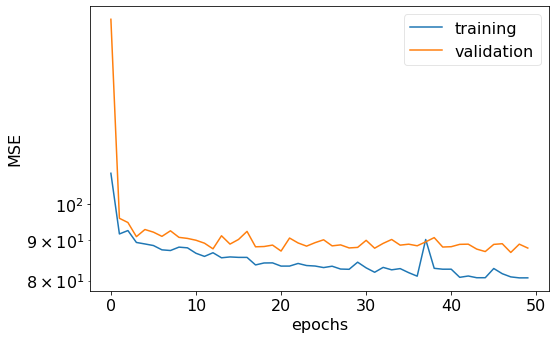

In [35]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

The reconstruction works the same, where we look at one decoded sample:

Text(0.5, 1.0, 'Reconstruced SSTA')

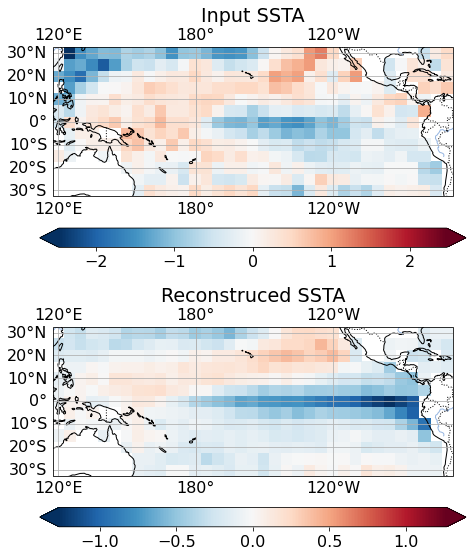

In [37]:
# select random inputs from validataion dataset
x, l = val_data[np.random.randint(0, len(val_data))]

# encode and decode input
x_rec, q_m, q_logv = vae.forward(x.to(vae.device))

# transform flattened map back to grid
da_in = val_data.dataset.get_map(x)
da_rec = val_data.dataset.get_map(x_rec[0])

# Plotting
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree(central_longitude=180))
)
ut.plot_map(da_in, ax=ax1, central_longitude=180)
ax1.set_title(f"Input SSTA")
ut.plot_map(da_rec, ax=ax2, central_longitude=180)
ax2.set_title("Reconstruced SSTA")

### Latent space 

Very similar to the AE we can plot the latent space of the VAE. Keep in mind, that we are only plotting the mean of the posterior distribution $p(z|x)$. 

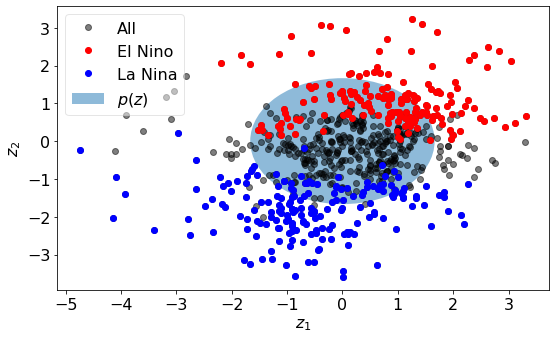

In [38]:
encode = encoding(vae, train_loader)

# get all encodings for El Nino and La Nina conditions
nino34_train = train_data.dataset.dataarray.sel(lat=slice(-5,5), lon=[10, 60]).mean(dim=('lon', 'lat'), skipna=True)
nino_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data > 0.5)[0]))
nina_idx = np.flatnonzero(np.isin(encode['idx'], np.where(nino34_train.data < -0.5)[0]))


fig, ax = plt.subplots()
# Prior
ut.plot_2dgaussian(np.zeros(2), np.diag(np.ones(2)), p=0.5, ax=ax, alpha=0.5, label=f'$p(z)$')
# Mean of p(z|x)
ax.plot(encode['z'][:, 0], encode['z'][:, 1], 'ko', label='All', alpha=0.5)
ax.plot(encode['z'][nino_idx, 0], encode['z'][nino_idx, 1], 'ro', label='El Nino')
ax.plot(encode['z'][nina_idx,0], encode['z'][nina_idx,1], 'bo', label='La Nina')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()


### Latent space traverse

The Gaussian assumption on the prior enforces that points which are similar in $x$ need to be close in $z$. That allows smooth transitions from one point to the other in latent space.

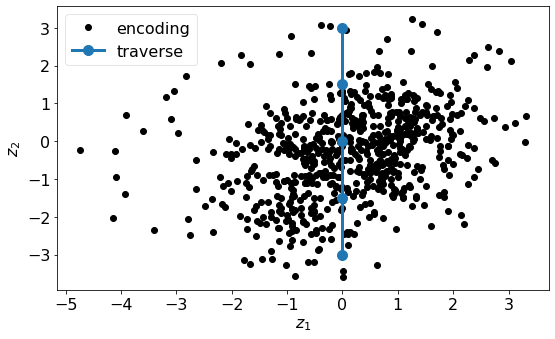

In [39]:
z_start = torch.Tensor([[0,0]])
z_eps = torch.Tensor([0,1])
z_range = torch.linspace(-3, 3, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1 ) + z_range.unsqueeze(1) * z_eps


# Plot latent space
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', label='encoding')
ax.plot(z_samples[:,0], z_samples[:,1], '-o', label='traverse', 
        markersize=10, linewidth=3)
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

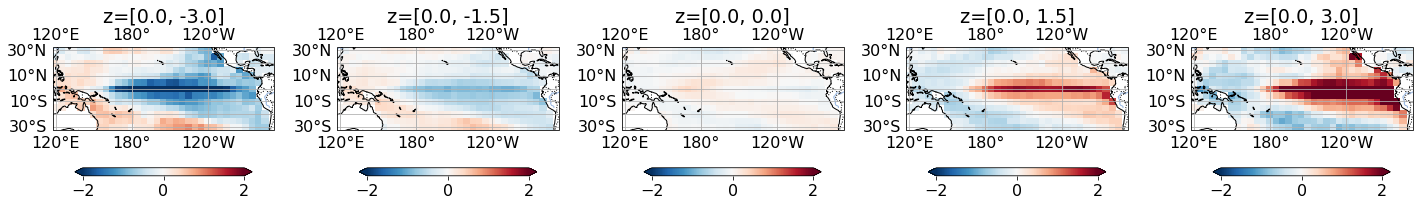

In [40]:
# Decode z
with torch.no_grad():
    traverse = vae.decoder(z_samples.to(ae.device))
    
# Plot reconstructions
fig, axs = plt.subplots(
    1, len(z_range), figsize=(len(z_range)*4, 4), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree(central_longitude=180))
)
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    ut.plot_map(da_rec, ax=axs[i], central_longitude=180, vmin=-2, vmax=2)
    axs[i].set_title(f"z={z_samples[i].tolist()}")

## More resources

1. [Blog by Lilian Weng](https://lilianweng.github.io/posts/2018-08-12-vae/)

2. [Mathy Bit blog](https://mathybit.github.io/auto-var/)

3. [Diederik P. Kingma, and Max Welling. “Auto-encoding variational bayes." ICLR 2014.](https://arxiv.org/abs/1312.6114)